# Calculating functional and taxonomic diversity of transporters

## Overview

Here we will use the [Shannon diversity index](https://en.wikipedia.org/wiki/Diversity_index) to calculate both taxonomic diversity of transporters and functional diversity of most abundant taxa in each sample.

In [1]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from skbio.diversity import alpha
from scipy.stats import spearmanr, wilcoxon
import numpy as np
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
plt.style.use('ggplot')

## Functionality

In [2]:
def shannon_proportions(counts,base=2):
    '''Modified version of shannon to handle proportions instead of absolute counts.'''
    counts = [float(item) for item in counts]
    counts = np.asarray(counts)
    if counts.sum()==0: return -1,0
    freqs = counts / counts.sum()
    nonzero_freqs = freqs[freqs.nonzero()]
    return -(nonzero_freqs * np.log(nonzero_freqs)).sum() / np.log(base),len(nonzero_freqs)

In [3]:
def transporter_taxonomic_diversity(df,ranks,transporters,data_type,taxa):
    data = pd.DataFrame(columns=["rank","sample","transporter","dataset","taxa","diversity","num_taxa"])
    index = -1
    for rank in ranks:
        # Sum to abundance per family for each rank
        tmp_sum = df.groupby([rank,"fam","transporter"]).sum().reset_index()
        # Get mean transporter abundance for each rank
        tmp_mean = tmp_sum.groupby(["transporter",rank]).mean().reset_index()
        samples = tmp_mean.columns[2:]
        for transporter in transporters:
            # Get transporter data
            tmp_trans = tmp_mean.loc[tmp_mean.transporter==transporter] 
            # Sum for the current rank and transporter
            tmp_trans_rank = tmp_trans.groupby(rank).sum() 
            # Normalize to % in each sample
            tmp_trans_rank_norm = tmp_trans_rank.div(tmp_trans_rank.sum())*100
            # Fill gaps
            tmp_trans_rank_norm.fillna(0,inplace=True)
            # For each sample, calculate diversity and number of taxa for this transporter
            for sample in samples:
                div,num_taxa = shannon_proportions(tmp_trans_rank_norm[sample])
                index+=1
                df_tmp = pd.DataFrame(index=[index],data={"rank":rank,"taxa":taxa,"dataset":data_type,"sample":sample,"transporter":transporter,"diversity":div,"num_taxa":num_taxa})
                data = pd.concat([data,df_tmp])
    return data

In [4]:
def taxonomic_functional_diversity(df,rank,data_type,t_quantile=0.9):
    # Create empty dataframe
    data = pd.DataFrame(columns=["taxa","sample","type","diversity","num_transporters"])
    # Sum to abundance per family for each rank
    tmp_sum = df.groupby([rank,"fam","transporter"]).sum().reset_index()
    # Get mean transporter abundance for each rank
    tmp_mean = tmp_sum.groupby(["transporter",rank]).mean().reset_index()
    # Get total transporter abundance for each rank (sum over all transporters)
    # Also remove unclassified orders and environmental samples
    tmp_mean = tmp_mean.loc[~tmp_mean[rank].str.contains("unclassified", case=False)]
    tmp_mean = tmp_mean.loc[~tmp_mean[rank].str.contains("environmental samples", case=False)]
    tmp_trans_tax_sum = tmp_mean.groupby(rank).sum()    
    samples = tmp_mean.columns[2:]
    index=-1
    for sample in samples:
        # Calculate taxa that make up the quantiles for the transporter data
        q_trans_taxa = list(tmp_trans_tax_sum.loc[tmp_trans_tax_sum[sample]>tmp_trans_tax_sum[sample].quantile(q=t_quantile)].index)
        sample_taxa = q_trans_taxa
        for tax in sample_taxa:
            # Get tax data
            tmp_tax_trans = tmp_mean.loc[tmp_mean[rank]==tax,sample] 
            # Normalize
            tmp_tax_trans_norm = tmp_tax_trans.div(tmp_tax_trans.sum())*100
            # Calculate diversity and number of transporters for this order in this sample
            div,num_transporters = shannon_proportions(tmp_tax_trans_norm)
            index+=1
            # Add to dataframe
            df_tmp = pd.DataFrame(index=[index],data={"taxa":tax,"type":data_type,"sample":sample,"diversity":div,"num_transporters":num_transporters})
            data = pd.concat([data,df_tmp])
    taxsort = list(tmp_trans_tax_sum.loc[list(set(data.taxa))].mean(axis=1).sort_values(ascending=False).index)
    return data,taxsort

## Read sample groups

In [5]:
mg_groups = pd.read_table("results/mg/samplegroups.tab", index_col=0)
mg_groups.rename(index=lambda x: str(x), inplace=True)

In [6]:
mt_groups = pd.read_table("results/mt/samplegroups.tab", index_col=0)
mt_groups.rename(index=lambda x: str(x), inplace=True)

## Read transporter/taxonomic data

In [7]:
mg_taxcov = pd.read_table("results/mg/select_trans_genes.tpm.tsv", index_col=0)
mt_taxcov = pd.read_table("results/mt/select_trans_genes.tpm.tsv", index_col=0)

Read information on transporters.

In [9]:
transinfo = pd.read_table("results/selected_transporters_classified.tab", index_col=0)

In [10]:
categories = ["Anions","Cations","NH3 Nitrate","Urea","phosphate","phosphonate","AA peptide","nucleoside","carbohydrate"]

Calculate functional diversity per sample for taxa at rank order. **For each sample, only consider taxa that are part of the upper 99% quantile.** This will hopefully make the functional diversity estimates more reliable.

In [11]:
tax_color_df = pd.read_table("results/taxcolors_order.tab", header=0, index_col=0)
tax_color_dict = {}
for t in tax_color_df.index:
    tax_color_dict[t] = (tax_color_df.loc[t,"0"],tax_color_df.loc[t,"1"],tax_color_df.loc[t,"2"])
tax_color_dict["Mamiellales"] = sns.xkcd_palette(["light teal"])[0]
tax_color_dict["Nostocales"] = sns.xkcd_palette(["grass green"])[0]
tax_color_dict["Synechococcales"] = sns.xkcd_palette(["chartreuse"])[0]

In [12]:
mg_tax_fun_div,mg_taxsort = taxonomic_functional_diversity(mg_taxcov,rank="order",t_quantile=0.9,data_type="mg")

Plot the functional diversity in the top 5 taxa.

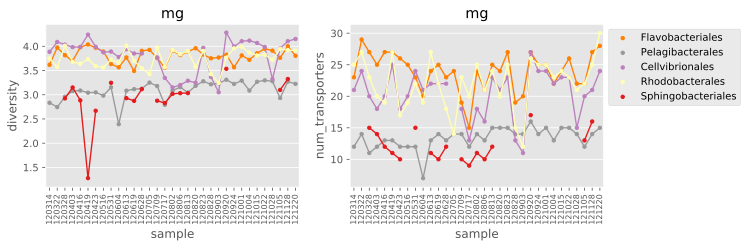

In [13]:
fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,3))
ax1 = sns.pointplot(data=mg_tax_fun_div.loc[mg_tax_fun_div.taxa.isin(mg_taxsort[0:5])],y="diversity",x="sample",hue="taxa",
                    scale=0.5, ax=axes[0],palette=tax_color_dict, hue_order=mg_taxsort[0:5])
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90, fontsize=8);
ax1.legend_.remove()
ax1.set_title("mg")

ax2 = sns.pointplot(data=mg_tax_fun_div.loc[mg_tax_fun_div.taxa.isin(mg_taxsort[0:5])],y="num_transporters",x="sample",hue="taxa",
                    scale=0.5, ax=axes[1],palette=tax_color_dict, hue_order=mg_taxsort[0:5])
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90, fontsize=8);
ax2.legend(bbox_to_anchor=(1,1))
ax2.set_title("mg")
plt.savefig("results/figures/mg_functional_diversity_top5_order.png",dpi=300,bbox_inches="tight")

In [14]:
mt_tax_fun_div,mt_taxsort = taxonomic_functional_diversity(mt_taxcov,rank="order",t_quantile=0.9,data_type="mt")

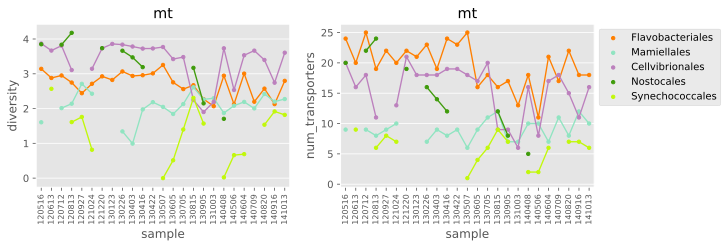

In [15]:
fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(10,3))
ax1 = sns.pointplot(data=mt_tax_fun_div.loc[mt_tax_fun_div.taxa.isin(mt_taxsort[0:5])],y="diversity",x="sample",hue="taxa",
                    scale=0.5, ax=axes[0],palette=tax_color_dict, hue_order=mt_taxsort[0:5])
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90, fontsize=8);
ax1.legend_.remove()
ax1.set_title("mt")

ax2 = sns.pointplot(data=mt_tax_fun_div.loc[mt_tax_fun_div.taxa.isin(mt_taxsort[0:5])],y="num_transporters",x="sample",hue="taxa",
                    scale=0.5, ax=axes[1],palette=tax_color_dict, hue_order=mt_taxsort[0:5])
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90, fontsize=8);
ax2.legend(bbox_to_anchor=(1,1))
ax2.set_title("mt")
plt.savefig("results/figures/mt_functional_diversity_top5_order.png",dpi=300,bbox_inches="tight")

Merge the MG and MT functional dataframes.

## Calculate diversity per transporter and rank.

Calculate for different subsets.

In [16]:
ranks = ["order"]
mg_trans_div = transporter_taxonomic_diversity(mg_taxcov,ranks,list(set(mg_taxcov.transporter)),"mg","all")
mg_trans_div_bac = transporter_taxonomic_diversity(mg_taxcov.loc[(mg_taxcov.superkingdom=="Bacteria")&(mg_taxcov.phylum!="Cyanobacteria")],ranks,list(set(mg_taxcov.transporter)),"mg","Bacteria")
mg_trans_div_euk = transporter_taxonomic_diversity(mg_taxcov.loc[mg_taxcov.superkingdom=="Eukaryota"],ranks,list(set(mg_taxcov.transporter)),"mg","Eukaryota")
mg_trans_div_cya = transporter_taxonomic_diversity(mg_taxcov.loc[mg_taxcov.phylum=="Cyanobacteria"],ranks,list(set(mg_taxcov.transporter)),"mg","Cyanobacteria")

In [17]:
ranks = ["order"]
mt_trans_div = transporter_taxonomic_diversity(mt_taxcov,ranks,list(set(mt_taxcov.transporter)),"mt","all")
mt_trans_div_bac = transporter_taxonomic_diversity(mt_taxcov.loc[(mt_taxcov.superkingdom=="Bacteria")&(mt_taxcov.phylum!="Cyanobacteria")],ranks,list(set(mt_taxcov.transporter)),"mt","Bacteria")
mt_trans_div_euk = transporter_taxonomic_diversity(mt_taxcov.loc[mt_taxcov.superkingdom=="Eukaryota"],ranks,list(set(mt_taxcov.transporter)),"mt","Eukaryota")
mt_trans_div_cya = transporter_taxonomic_diversity(mt_taxcov.loc[mt_taxcov.phylum=="Cyanobacteria"],ranks,list(set(mt_taxcov.transporter)),"mt","Cyanobacteria")

Combine dataframes.

In [18]:
transporter_diversity = pd.concat([mg_trans_div,mg_trans_div_bac])
transporter_diversity = pd.concat([transporter_diversity,mg_trans_div_euk])
transporter_diversity = pd.concat([transporter_diversity,mg_trans_div_cya])

In [19]:
transporter_diversity = pd.concat([transporter_diversity,mt_trans_div])
transporter_diversity = pd.concat([transporter_diversity,mt_trans_div_bac])
transporter_diversity = pd.concat([transporter_diversity,mt_trans_div_euk])
transporter_diversity = pd.concat([transporter_diversity,mt_trans_div_cya])

Merge with transporter info.

In [20]:
transporter_diversity = pd.merge(transporter_diversity,transinfo,left_on="transporter",right_index=True)

In [21]:
transporter_diversity.to_csv("results/transporter_diversity.tab", sep="\t")

In [22]:
transporter_diversity.head()

,dataset,diversity,num_taxa,rank,sample,taxa,transporter,substrate_category,type,name,abbreviation
0,mg,3.02647,20,order,120314,all,T287,Urea,3a,urea_urt: urea ABC transporter,NO
1,mg,2.78789,22,order,120322,all,T287,Urea,3a,urea_urt: urea ABC transporter,NO
2,mg,3.68191,20,order,120328,all,T287,Urea,3a,urea_urt: urea ABC transporter,NO
3,mg,3.16975,13,order,120403,all,T287,Urea,3a,urea_urt: urea ABC transporter,NO
4,mg,3.08888,13,order,120416,all,T287,Urea,3a,urea_urt: urea ABC transporter,NO


## Read diversity and plot

In [23]:
transporter_diversity = pd.read_table("results/transporter_diversity.tab", index_col=0)

### Plot bars for each category, by taxa and dataset

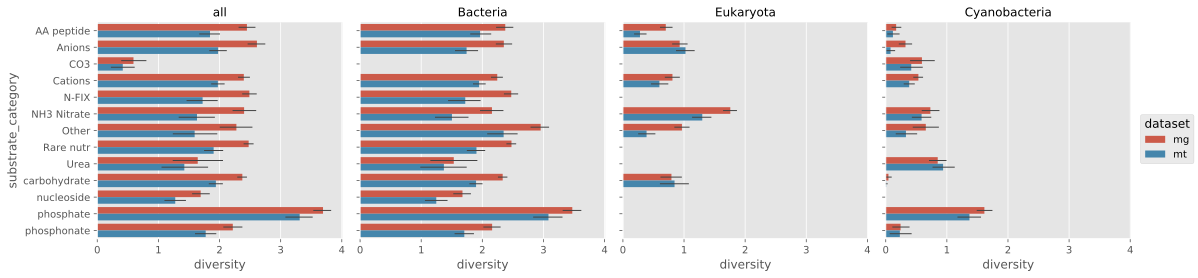

In [24]:
ax = sns.factorplot(data=transporter_diversity.loc[transporter_diversity.diversity>=0],
                    col_order = ["all","Bacteria","Eukaryota","Cyanobacteria"],x="diversity",y="substrate_category",hue="dataset",col="taxa",kind="bar",aspect=1,order=sorted(list(set(transporter_diversity.substrate_category))),errwidth=1)
ax.set_titles("{col_name}");
plt.savefig("results/figures/transporter_diversity.png",dpi=300,bbox_inches="tight")

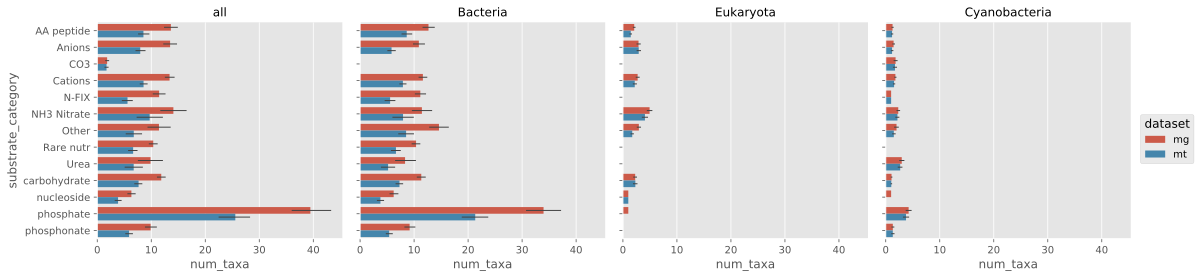

In [25]:
ax = sns.factorplot(data=transporter_diversity.loc[transporter_diversity.diversity>=0],
                    col_order = ["all","Bacteria","Eukaryota","Cyanobacteria"],x="num_taxa",y="substrate_category",hue="dataset",col="taxa",kind="bar",aspect=1,order=sorted(list(set(transporter_diversity.substrate_category))),errwidth=1)
ax.set_titles("{col_name}");
plt.savefig("results/figures/transporter_numtaxa.png",dpi=300,bbox_inches="tight")

## Plot profiles for select transporter substrates

Generate transporter means in each taxgroup.

In [60]:
mg_bac_sum = mg_taxcov.loc[(mg_taxcov.superkingdom=="Bacteria")&(mg_taxcov.phylum!="Cyanobacteria")].groupby(["fam","transporter"]).sum()
mg_bac_mean = mg_bac_sum.groupby("transporter").mean()
mg_bac_meanp = mg_bac_mean.div(mg_bac_mean.sum())*100
mg_bac_meanp = pd.merge(transinfo,mg_bac_meanp,left_index=True, right_index=True)
mg_bac_melt = pd.melt(mg_bac_meanp.reset_index()[["transporter","substrate_category"]+list(mg_bac_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mg_bac_melt = mg_bac_melt.assign(Taxgroup=pd.Series(["Bacteria"]*len(mg_bac_melt)))

In [61]:
mg_arc_sum = mg_taxcov.loc[(mg_taxcov.superkingdom=="Archaea")].groupby(["fam","transporter"]).sum()
mg_arc_mean = mg_arc_sum.groupby("transporter").mean()
mg_arc_meanp = mg_arc_mean.div(mg_arc_mean.sum())*100
mg_arc_meanp = pd.merge(transinfo,mg_arc_meanp,left_index=True, right_index=True)
mg_arc_melt = pd.melt(mg_arc_meanp.reset_index()[["transporter","substrate_category"]+list(mg_arc_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mg_arc_melt = mg_arc_melt.assign(Taxgroup=pd.Series(["Archaea"]*len(mg_arc_melt)))

In [62]:
mg_cya_sum = mg_taxcov.loc[(mg_taxcov.phylum=="Cyanobacteria")].groupby(["fam","transporter"]).sum()
mg_cya_mean = mg_cya_sum.groupby("transporter").mean()
mg_cya_meanp = mg_cya_mean.div(mg_cya_mean.sum())*100
mg_cya_meanp = pd.merge(transinfo,mg_cya_meanp,left_index=True, right_index=True)
mg_cya_melt = pd.melt(mg_cya_meanp.reset_index()[["transporter","substrate_category"]+list(mg_cya_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mg_cya_melt = mg_cya_melt.assign(Taxgroup=pd.Series(["Cyanobacteria"]*len(mg_cya_melt)))

In [63]:
mg_euk_sum = mg_taxcov.loc[(mg_taxcov.superkingdom=="Eukaryota")].groupby(["fam","transporter"]).sum()
mg_euk_mean = mg_euk_sum.groupby("transporter").mean()
mg_euk_meanp = mg_euk_mean.div(mg_euk_mean.sum())*100
mg_euk_meanp = pd.merge(transinfo,mg_euk_meanp,left_index=True, right_index=True)
mg_euk_melt = pd.melt(mg_euk_meanp.reset_index()[["transporter","substrate_category"]+list(mg_euk_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mg_euk_melt = mg_euk_melt.assign(Taxgroup=pd.Series(["Eukaryota"]*len(mg_euk_melt)))

In [64]:
mg_melt = pd.concat([mg_bac_melt,mg_cya_melt])
mg_melt = pd.concat([mg_melt,mg_arc_melt])
mg_melt = pd.concat([mg_melt,mg_euk_melt])

In [65]:
mt_bac_sum = mt_taxcov.loc[(mt_taxcov.superkingdom=="Bacteria")&(mt_taxcov.phylum!="Cyanobacteria")].groupby(["fam","transporter"]).sum()
mt_bac_mean = mt_bac_sum.groupby("transporter").mean()
mt_bac_meanp = mt_bac_mean.div(mt_bac_mean.sum())*100
mt_bac_meanp = pd.merge(transinfo,mt_bac_meanp,left_index=True, right_index=True)
mt_bac_melt = pd.melt(mt_bac_meanp.reset_index()[["transporter","substrate_category"]+list(mt_bac_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mt_bac_melt = mt_bac_melt.assign(Taxgroup=pd.Series(["Bacteria"]*len(mt_bac_melt)))

In [66]:
mt_arc_sum = mt_taxcov.loc[(mt_taxcov.superkingdom=="Archaea")].groupby(["fam","transporter"]).sum()
mt_arc_mean = mt_arc_sum.groupby("transporter").mean()
mt_arc_meanp = mt_arc_mean.div(mt_arc_mean.sum())*100
mt_arc_meanp = pd.merge(transinfo,mt_arc_meanp,left_index=True, right_index=True)
mt_arc_melt = pd.melt(mt_arc_meanp.reset_index()[["transporter","substrate_category"]+list(mt_arc_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mt_arc_melt = mt_arc_melt.assign(Taxgroup=pd.Series(["Archaea"]*len(mt_arc_melt)))

In [67]:
mt_cya_sum = mt_taxcov.loc[(mt_taxcov.phylum=="Cyanobacteria")].groupby(["fam","transporter"]).sum()
mt_cya_mean = mt_cya_sum.groupby("transporter").mean()
mt_cya_meanp = mt_cya_mean.div(mt_cya_mean.sum())*100
mt_cya_meanp = pd.merge(transinfo,mt_cya_meanp,left_index=True, right_index=True)
mt_cya_melt = pd.melt(mt_cya_meanp.reset_index()[["transporter","substrate_category"]+list(mt_cya_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mt_cya_melt = mt_cya_melt.assign(Taxgroup=pd.Series(["Cyanobacteria"]*len(mt_cya_melt)))

In [68]:
mt_euk_sum = mt_taxcov.loc[(mt_taxcov.superkingdom=="Eukaryota")].groupby(["fam","transporter"]).sum()
mt_euk_mean = mt_euk_sum.groupby("transporter").mean()
mt_euk_meanp = mt_euk_mean.div(mt_euk_mean.sum())*100
mt_euk_meanp = pd.merge(transinfo,mt_euk_meanp,left_index=True, right_index=True)
mt_euk_melt = pd.melt(mt_euk_meanp.reset_index()[["transporter","substrate_category"]+list(mt_euk_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mt_euk_melt = mt_euk_melt.assign(Taxgroup=pd.Series(["Eukaryota"]*len(mt_euk_melt)))

In [69]:
mt_melt = pd.concat([mt_bac_melt,mt_cya_melt])
mt_melt = pd.concat([mt_melt,mt_arc_melt])
mt_melt = pd.concat([mt_melt,mt_euk_melt])

### Phosphate/phosphonate

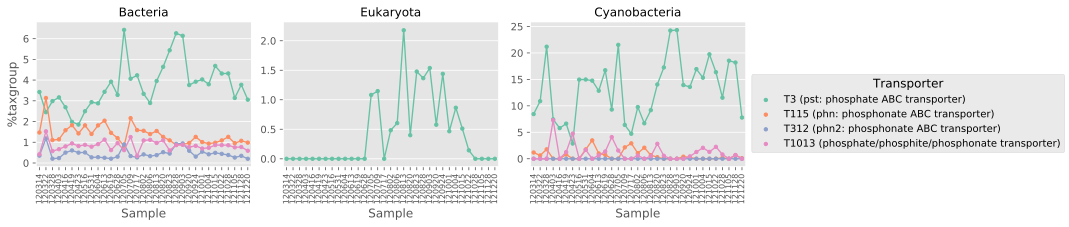

In [34]:
cats = ["phosphate","phosphonate"]
plot_data = mg_melt.loc[mg_melt.substrate_category.isin(cats)]
renamed_trans = []
for t in plot_data.transporter:
    renamed_trans.append("{} ({})".format(t,transinfo.loc[t,"name"]))
plot_data = plot_data.assign(Transporter=pd.Series(renamed_trans,index=plot_data.index))
ax = sns.factorplot(data=plot_data, x="Sample", hue="Transporter", y="%taxgroup", palette="Set2", col="Taxgroup", col_order=["Bacteria","Eukaryota","Cyanobacteria"],
              size=3, aspect=1.2, scale=0.5, sharey=False)
ax.set_titles("{col_name}")
ax.set_xticklabels(rotation=90, fontsize=8)
plt.subplots_adjust(wspace=0.15)
plt.savefig("results/figures/mg_p_transporters_taxgroups.png", dpi=300, bbox_to_inches="tight")

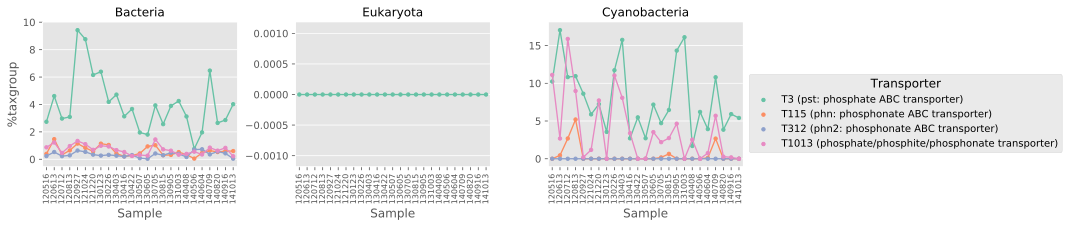

In [76]:
cats = ["phosphate","phosphonate"]
plot_data = mt_melt.loc[mt_melt.substrate_category.isin(cats)]
renamed_trans = []
for t in plot_data.transporter:
    renamed_trans.append("{} ({})".format(t,transinfo.loc[t,"name"]))
plot_data = plot_data.assign(Transporter=pd.Series(renamed_trans,index=plot_data.index))
ax = sns.factorplot(data=plot_data, x="Sample", hue="Transporter", y="%taxgroup", palette="Set2", col="Taxgroup", col_order=["Bacteria","Eukaryota","Cyanobacteria"],
              size=3, aspect=1.2, scale=0.5, sharey=False)
ax.set_titles("{col_name}")
ax.set_xticklabels(rotation=90, fontsize=8)
plt.subplots_adjust(wspace=0.3)
plt.savefig("results/figures/mt_p_transporters_taxgroups.png", dpi=300, bbox_to_inches="tight")

### Nitrogen compounds

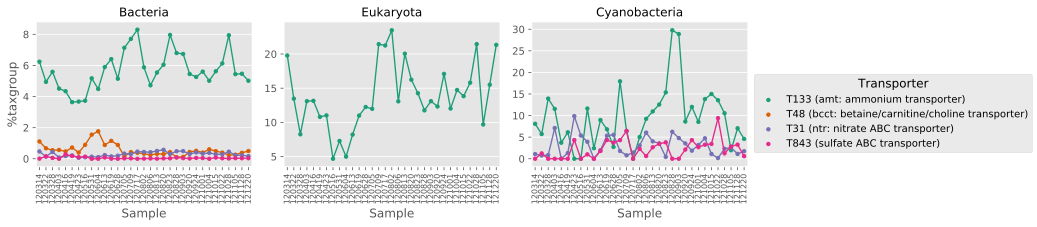

In [52]:
cats = ["NH3 Nitrate"]
plot_data = mg_melt.loc[mg_melt.substrate_category.isin(cats)]
renamed_trans = []
for t in plot_data.transporter:
    renamed_trans.append("{} ({})".format(t,transinfo.loc[t,"name"]))
plot_data = plot_data.assign(Transporter=pd.Series(renamed_trans,index=plot_data.index))
ax = sns.factorplot(data=plot_data, x="Sample", hue="Transporter", y="%taxgroup", palette="Dark2", col="Taxgroup", col_order=["Bacteria","Eukaryota","Cyanobacteria"],
              size=3, aspect=1.2, scale=0.5, sharey=False)
ax.set_titles("{col_name}")
ax.set_xticklabels(rotation=90, fontsize=8)
plt.subplots_adjust(wspace=0.15)
plt.savefig("results/figures/mg_n_transporters_taxgroups.png", dpi=300, bbox_to_inches="tight")

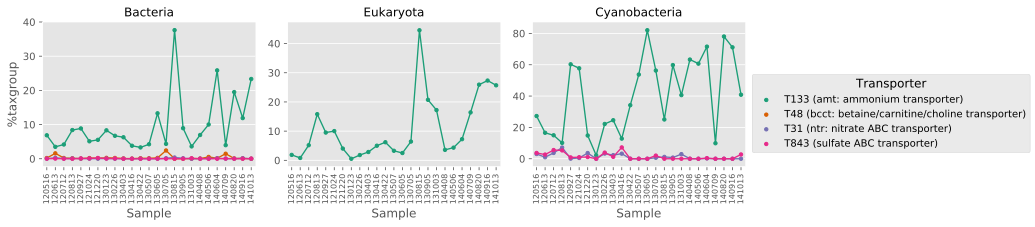

In [71]:
cats = ["NH3 Nitrate"]
plot_data = mt_melt.loc[mt_melt.substrate_category.isin(cats)]
renamed_trans = []
for t in plot_data.transporter:
    renamed_trans.append("{} ({})".format(t,transinfo.loc[t,"name"]))
plot_data = plot_data.assign(Transporter=pd.Series(renamed_trans,index=plot_data.index))
ax = sns.factorplot(data=plot_data, x="Sample", hue="Transporter", y="%taxgroup", palette="Dark2", col="Taxgroup", col_order=["Bacteria","Eukaryota","Cyanobacteria"],
              size=3, aspect=1.2, scale=0.5, sharey=False)
ax.set_titles("{col_name}")
ax.set_xticklabels(rotation=90, fontsize=8)
plt.subplots_adjust(wspace=0.15)
plt.savefig("results/figures/mt_n_transporters_taxgroups.png", dpi=300, bbox_to_inches="tight")

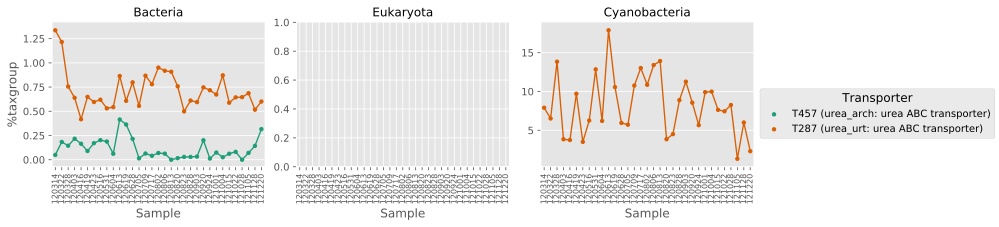

In [74]:
cats = ["Urea"]
plot_data = mg_melt.loc[mg_melt.substrate_category.isin(cats)]
renamed_trans = []
for t in plot_data.transporter:
    renamed_trans.append("{} ({})".format(t,transinfo.loc[t,"name"]))
plot_data = plot_data.assign(Transporter=pd.Series(renamed_trans,index=plot_data.index))
ax = sns.factorplot(data=plot_data, x="Sample", hue="Transporter", y="%taxgroup", palette="Dark2", col="Taxgroup", col_order=["Bacteria","Eukaryota","Cyanobacteria"],
              size=3, aspect=1.2, scale=0.5, sharey=False)
ax.set_titles("{col_name}")
ax.set_xticklabels(rotation=90, fontsize=8)
plt.subplots_adjust(wspace=0.15)
plt.savefig("results/figures/mg_urea_transporters_taxgroups.png", dpi=300, bbox_to_inches="tight")

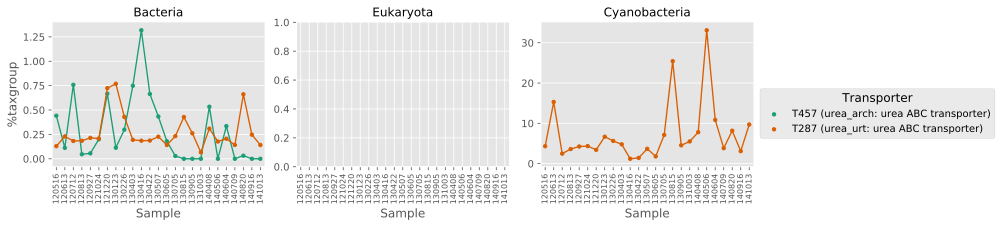

In [55]:
cats = ["Urea"]
plot_data = mt_melt.loc[mt_melt.substrate_category.isin(cats)]
renamed_trans = []
for t in plot_data.transporter:
    renamed_trans.append("{} ({})".format(t,transinfo.loc[t,"name"]))
plot_data = plot_data.assign(Transporter=pd.Series(renamed_trans,index=plot_data.index))
ax = sns.factorplot(data=plot_data, x="Sample", hue="Transporter", y="%taxgroup", palette="Dark2", col="Taxgroup", col_order=["Bacteria","Eukaryota","Cyanobacteria"],
              size=3, aspect=1.2, scale=0.5, sharey=False)
ax.set_titles("{col_name}")
ax.set_xticklabels(rotation=90, fontsize=8)
plt.subplots_adjust(wspace=0.15)
plt.savefig("results/figures/mt_urea_transporters_taxgroups.png", dpi=300, bbox_to_inches="tight")